<a href="https://colab.research.google.com/github/DataChemE/generative-opthalmology/blob/main/opthalmologic_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
import torchvision

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

In [2]:
# Connect google drive to colab for training on the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Google Drive base directory
BASE_DIR = '/content/drive/MyDrive/'

# Local Base Directory
# BASE_DIR = './'

# Define the path to the fundus photos

# Local image path
#IMAGE_PATH = '/Volumes/Extreme SSD/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

# Google drive image path
IMAGE_PATH = '/content/drive/MyDrive/a-brazilian-multilabel-ophthalmological-dataset-brset-1.0.0/fundus_photos/'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
BATCH_SIZE = 64
NUM_WORKERS = 2
IMAGE_SIZE = 64
nc = 3
nz = 100
ndf = 64
ngf = 64
num_epochs = 100
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [32]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import logging

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = []
        for f in os.listdir(img_dir):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('._'):
                self.images.append(f)
        logging.info(f"Found {len(self.images)} valid image files.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except (IOError, OSError) as e:
            logging.error(f"Error opening image {img_path}: {e}")
            # Return a blank image or skip this image
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        return image

# Set up logging
logging.basicConfig(level=logging.INFO)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


dataset = CustomImageDataset(img_dir=IMAGE_PATH, transform=transform)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


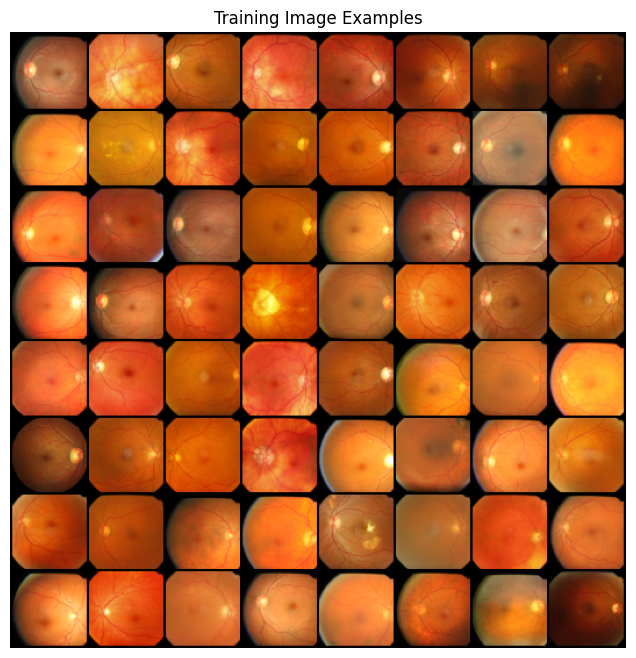

In [31]:
# Plot images examples
def plot_images(dataloader):
    batch_example = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title("Training Image Examples")

    # only plot 64 images or less
    num_images = min(64, batch_example.size(0))

    grid = torchvision.utils.make_grid(batch_example[:num_images], padding=2, normalize=True)
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.show()

plot_images(dataloader)

In [20]:
# Define the initial weights

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [23]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        # input values
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias = False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),

        # size now (ngf * 8) * 4 * 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),

        # size now (ngf * 8) * 8 * 8
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),


        # size now (ngf * 4) * 16 * 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        # state size now (ngf * 32 * 32)
        nn.ConvTranspose2d(ngf, nc, 4, 2, 1 , bias = False),
        nn.Tanh()

                           )

  def forward (self, input):
    return self.main(input)


In [26]:
# create generator

gen = Generator(ngpu).to(DEVICE)
gen.apply(weights_init)
print(gen)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(4, 4), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [30]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
        #input of image size
        nn.Conv2d(nc, ndf, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace = True),

        # state size 32 by 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(.2, inplace = True),

        # state size 16 * 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d( ndf * 4),
        nn.LeakyReLU(.2, inplace = True),

        # state size 8 * 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(.2, inplace = True),

        # state size 4 * 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias = False),
        nn.Sigmoid()
    )

    def forward(self, input):
      return self.main(input)



In [28]:
disc = Discriminator(ngpu).to(DEVICE)
disc.apply(weights_init)
print(disc)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [29]:
# loss function and optimizers

loss = nn.BCELoss()

# create noise to show the progression of the generator
noise = torch.randn(64, nz, 1, 1, device = DEVICE)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(disc.parameters(), lr = lr, betas = (beta1, .999))
optimizerG = optim.Adam(gen.parameters(), lr = lr, betas = (beta1, .999))



In [40]:
# define training loop


generator_loss = []
discriminator_loss = []
iters = 0
image_list = []

for epoch in range(num_epochs):

  for i, data in enumerate(dataloader, 0):

    disc.zero_grad()
    real_cpu = data[0].to(DEVICE)
    b_size = real_cpu.size(0)
    label = torch.full((b_size,), real_label, dtype = torch.float, device = DEVICE)

    output = disc(real_cpu).view(-1)
    errdisc_real = loss(output, label)
    errdisc_real.backward()
    D_x = output.mean().item()

    # train with fake images batch
    noise = torch.randn(b_size, nz, 1,1, device = DEVICE)
    fake = gen(noise)
    label.fill_(fake_label)
    output = disc(fake.detach()).view(-1)
    errdisc_fake = loss(output, label)
    errdisc_fake.backward()
    D_G_z1 = output.mean().item()
    errdisc = errdisc_real + errdisc_fake
    optimizerD.step()

    # update the generator to maximize the log(d(g(z)))
    output = disc(fake).view(-1)
    errgen = loss(output, label)
    errgen.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

  if i % 50 == 0:
    print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t'
      f'Loss_D: {errdisc.item():.4f}\tLoss_G: {errgen.item():.4f}\t'
      f'D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

    generator_loss.append(errgen.item())
    discriminator_loss.append(errdisc.item())


    if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
        with torch.no_grad():
          fake = gen(noise).detach().cpu()
          image_list.append(torchvision.utils.make_grid(fake, padding = 2, normalize = True))

        iters += 1

NotImplementedError: Module [Discriminator] is missing the required "forward" function

In [ ]:
# print out the results

plt.figure(figsize = (10,5))
plt.title("Generator and disc loss")
plt.plot(generator_loss, label = "G")
plt.plot(discriminator_loss, label = "D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
real_batch = next(iter(dataloader))

# plot the real images

plt.figure(figsize = 15, 15)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("real images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE)[:64], padding = 5, normalize = True).cpu(), (1,2,0)))


plt.subplot(1,2,1)
plt.axis("off")
plt.title("fake images")
plt.imshow(np.transpose(img_list[-1], (1,2,0)))
plt.show()